# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("Data Exploration Phase:")
print("Udacity_AZDIAS_Subset.csv shape: ", azdias.shape)
print("AZDIAS_Feature_Summary.csv shape: ", feat_info.shape)
print("----")
print("Udacity_AZDIAS_Subset.csv snippet: ")
print(azdias.head())
print("----")
print("AZDIAS_Feature_Summary.csv snippet: ")
print(feat_info.head())
print("----")
print("Udacity_AZDIAS_Subset.csv stats: ")
print(azdias.describe())
print("----")
print("AZDIAS_Feature_Summary.csv stats: ")
print(feat_info.describe())
print("Done.")

Data Exploration Phase:
Udacity_AZDIAS_Subset.csv shape:  (891221, 85)
AZDIAS_Feature_Summary.csv shape:  (85, 4)
----
Udacity_AZDIAS_Subset.csv snippet: 
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  F

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.

# Create a dict for attribute's bad data values
bad_data_dict = dict(zip(feat_info['attribute'], feat_info['missing_or_unknown']))

# Loop through dict because we need to correct the string/integer problem it has in the list
# Note: there is probably an easier/more eloquant way to do this (come back and research if I have time)
for attrib, bad_data in bad_data_dict.items():
    bad_data = bad_data.strip('[]')
    bad_data_fixed = []
    #print("[DEBUG] bad_data: ", bad_data)
    for bad_data_item in bad_data.split(","):
        #print("[DEBUG] bad_data_item: ", bad_data_item)
        try:
            bad_data_fixed.append(int(bad_data_item))
            #print("DEBUG: is a digit")
        except ValueError:
            bad_data_fixed.append(str(bad_data_item))
            #print("DEBUG: is a string")            
    print(attrib, ': ', bad_data_fixed)
    bad_data_dict[attrib] = bad_data_fixed
bad_data_dict

# Moved below to a new cell
#azdias_clean = azdias.replace(bad_data_dict, np.NaN)

AGER_TYP :  [-1, 0]
ALTERSKATEGORIE_GROB :  [-1, 0, 9]
ANREDE_KZ :  [-1, 0]
CJT_GESAMTTYP :  [0]
FINANZ_MINIMALIST :  [-1]
FINANZ_SPARER :  [-1]
FINANZ_VORSORGER :  [-1]
FINANZ_ANLEGER :  [-1]
FINANZ_UNAUFFAELLIGER :  [-1]
FINANZ_HAUSBAUER :  [-1]
FINANZTYP :  [-1]
GEBURTSJAHR :  [0]
GFK_URLAUBERTYP :  ['']
GREEN_AVANTGARDE :  ['']
HEALTH_TYP :  [-1, 0]
LP_LEBENSPHASE_FEIN :  [0]
LP_LEBENSPHASE_GROB :  [0]
LP_FAMILIE_FEIN :  [0]
LP_FAMILIE_GROB :  [0]
LP_STATUS_FEIN :  [0]
LP_STATUS_GROB :  [0]
NATIONALITAET_KZ :  [-1, 0]
PRAEGENDE_JUGENDJAHRE :  [-1, 0]
RETOURTYP_BK_S :  [0]
SEMIO_SOZ :  [-1, 9]
SEMIO_FAM :  [-1, 9]
SEMIO_REL :  [-1, 9]
SEMIO_MAT :  [-1, 9]
SEMIO_VERT :  [-1, 9]
SEMIO_LUST :  [-1, 9]
SEMIO_ERL :  [-1, 9]
SEMIO_KULT :  [-1, 9]
SEMIO_RAT :  [-1, 9]
SEMIO_KRIT :  [-1, 9]
SEMIO_DOM :  [-1, 9]
SEMIO_KAEM :  [-1, 9]
SEMIO_PFLICHT :  [-1, 9]
SEMIO_TRADV :  [-1, 9]
SHOPPER_TYP :  [-1]
SOHO_KZ :  [-1]
TITEL_KZ :  [-1, 0]
VERS_TYP :  [-1]
ZABEOTYP :  [-1, 9]
ALTER_HH :  [0]
ANZ

{'AGER_TYP': [-1, 0],
 'ALTERSKATEGORIE_GROB': [-1, 0, 9],
 'ALTER_HH': [0],
 'ANREDE_KZ': [-1, 0],
 'ANZ_HAUSHALTE_AKTIV': [0],
 'ANZ_HH_TITEL': [''],
 'ANZ_PERSONEN': [''],
 'ANZ_TITEL': [''],
 'ARBEIT': [-1, 9],
 'BALLRAUM': [-1],
 'CAMEO_DEUG_2015': [-1, 'X'],
 'CAMEO_DEU_2015': ['XX'],
 'CAMEO_INTL_2015': [-1, 'XX'],
 'CJT_GESAMTTYP': [0],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEBAEUDETYP_RASTER': [''],
 'GEBURTSJAHR': [0],
 'GFK_URLAUBERTYP': [''],
 'GREEN_AVANTGARDE': [''],
 'HEALTH_TYP': [-1, 0],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_GBZ': [-1, 0],
 'KBA13_ANZAHL_PKW': [''],
 'KKK': [-1, 0],
 'KK_KUNDENTYP': [-1],
 'KONSUMNAEHE': [''],
 'LP_FAMILIE_FEIN': 

In [5]:
# Replace the bad data values with NaN
azdias_clean = azdias.replace(bad_data_dict, np.NaN)
azdias_clean.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

removal_candidates = []
histogram_dict = {}
row_cnt = azdias_clean.shape[0]
for col in azdias_clean:
    col_vals = azdias_clean[col].value_counts(dropna=False)
    try:
        histogram_dict[col] = col_vals[np.NaN]
        pct = col_vals[np.NaN]/row_cnt
        print("{col} missing/unknown: {cnt} ({pct:.2%})".format(col=col,
                                                            cnt=col_vals[np.NaN],
                                                            pct=pct))
        # Removal candidates have a quarter or more of its data missing
        if pct >= 0.25:
            removal_candidates.append(col)
    except:
        #Commenting out to make histogram look better
        #histogram_dict[col] = 0
        print(col, " missing/unknown: 0")



AGER_TYP missing/unknown: 685843 (76.96%)
ALTERSKATEGORIE_GROB missing/unknown: 2881 (0.32%)
ANREDE_KZ  missing/unknown: 0
CJT_GESAMTTYP missing/unknown: 4854 (0.54%)
FINANZ_MINIMALIST  missing/unknown: 0
FINANZ_SPARER  missing/unknown: 0
FINANZ_VORSORGER  missing/unknown: 0
FINANZ_ANLEGER  missing/unknown: 0
FINANZ_UNAUFFAELLIGER  missing/unknown: 0
FINANZ_HAUSBAUER  missing/unknown: 0
FINANZTYP  missing/unknown: 0
GEBURTSJAHR missing/unknown: 392318 (44.02%)
GFK_URLAUBERTYP missing/unknown: 4854 (0.54%)
GREEN_AVANTGARDE  missing/unknown: 0
HEALTH_TYP missing/unknown: 111196 (12.48%)
LP_LEBENSPHASE_FEIN missing/unknown: 97632 (10.95%)
LP_LEBENSPHASE_GROB missing/unknown: 94572 (10.61%)
LP_FAMILIE_FEIN missing/unknown: 77792 (8.73%)
LP_FAMILIE_GROB missing/unknown: 77792 (8.73%)
LP_STATUS_FEIN missing/unknown: 4854 (0.54%)
LP_STATUS_GROB missing/unknown: 4854 (0.54%)
NATIONALITAET_KZ missing/unknown: 108315 (12.15%)
PRAEGENDE_JUGENDJAHRE missing/unknown: 108164 (12.14%)
RETOURTYP_BK_S 

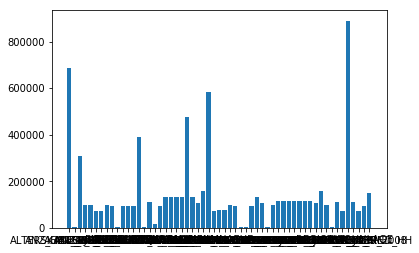

Candidate columns to remove:
AGER_TYP : 685843 (76.96%)
GEBURTSJAHR : 392318 (44.02%)
TITEL_KZ : 889061 (99.76%)
ALTER_HH : 310267 (34.81%)
KK_KUNDENTYP : 584612 (65.60%)
KBA05_BAUMAX : 476524 (53.47%)


In [7]:
# This looks pretty cluttered - I could limit the amount of data shown if I need to
plt.bar(list(histogram_dict.keys()), histogram_dict.values())
plt.show()

# Print out candidate features to remove based on percentage of missing/unknown
print("Candidate columns to remove:")
for rc in removal_candidates:
    print("{col} : {cnt} ({pct:.2%})".format(col=rc,
                                            cnt=histogram_dict[rc],
                                            pct=histogram_dict[rc]/row_cnt))

In [8]:
# Comment on histogram above:
# We can see that the 6 candidate columns to remove are apparent in the histogram (spikes) despite not
# being able to clearly read the X-axis given the number of features. (We could rebuild the histogram
# dictionary and only display those features with 10% or more for better readability)

# Investigate patterns in the amount of missing data in each column.
# Note: there are many columns that seem to have the same number of missing/unknown values- print them
pattern_dict = {}
for attrib, missing_cnt in (histogram_dict.items()):
    if missing_cnt in pattern_dict:
        pattern_dict[missing_cnt].append(attrib)
    else:
        pattern_dict[missing_cnt] = [attrib]
print("Showing potential correlated features based on missing/unknown value counts:")
for missing_cnt, attribs in (pattern_dict.items()):
    if len(attribs) > 1:
        print("{cnt}: {list}".format(cnt=missing_cnt, list=attribs))

Showing potential correlated features based on missing/unknown value counts:
4854: ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET']
111196: ['HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP']
77792: ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB']
73499: ['SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008']
93148: ['GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'WOHNLAGE']
133324: ['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO']
93740: ['BALLRAUM', 'EWDICHTE', 'INNENSTADT']
158064: ['KKK', 'REGIOTYP']
116515: ['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ']
97375: ['ARBEIT', 'RELAT_AB']


In [9]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Make a copy before we start dropping things
azdias_clean_v2 = azdias_clean.copy()

# Removing the 6 candidate columns identified above
print("[DEBUG] ", azdias_clean_v2.shape)
for rc in removal_candidates:
    print("[DEBUG] dropping ", rc)
    azdias_clean_v2 = azdias_clean_v2.drop(rc, axis=1)
print("[DEBUG] ", azdias_clean_v2.shape)

[DEBUG]  (891221, 85)
[DEBUG] dropping  AGER_TYP
[DEBUG] dropping  GEBURTSJAHR
[DEBUG] dropping  TITEL_KZ
[DEBUG] dropping  ALTER_HH
[DEBUG] dropping  KK_KUNDENTYP
[DEBUG] dropping  KBA05_BAUMAX
[DEBUG]  (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

##### Removal of Missing Data
From the histogram above it was apparent that there were 6 outliers (spikes) above the 200000 range - these corresponded to candidate features for removal that all had >25% of their values missing/unknown. These outliers were removed due to the amount of their missing/unknown values/rows (sparse features) which could negatively impact the clustering later on:

| Feature | Missing Value Count (pct) |
|---------|---------------------------|
| AGER_TYP | 685843 (76.96%) |
| GEBURTSJAHR | 392318 (44.02%) |
| TITEL_KZ | 889061 (99.76%) |
| ALTER_HH | 310267 (34.81%) |
| KK_KUNDENTYP | 584612 (65.60%) |
| KBA05_BAUMAX | 476524 (53.47%) |

##### Patterns of Missing Data
When looking at the amount of missing data per feature, it was readily apparent that there were a number of features that had the exact same number of missing values/rows. This is likely due to correlations among these features- for example if an address is broken down into a number of sub-features: house number, street name, city, state, zip -- but the address information is missing for a person, then all of these sub-features will be missing. In order to identify these correlations I printed out the list of features each having the same missing value counts -- these features may be able to be combined/encoded later on (e.g., in the example I mentioned those sub-features could be combined into a single "address" feature). Here are the feature lists corresponding to the same missing value counts:

| Missing Cnt | Features List |
|-------------|---------------|
| 4854 | CJT_GESAMTTYP, GFK_URLAUBERTYP, LP_STATUS_FEIN, LP_STATUS_GROB, RETOURTYP_BK_S, ONLINE_AFFINITAET
| 111196 | HEALTH_TYP, SHOPPER_TYP, VERS_TYP
| 77792 | LP_FAMILIE_FEIN, LP_FAMILIE_GROB
| 73499 | SOHO_KZ, ANZ_PERSONEN, ANZ_TITEL, WOHNDAUER_2008
| 93148 | GEBAEUDETYP, MIN_GEBAEUDEJAHR, WOHNLAGE
| 133324|  KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4, KBA05_GBZ, MOBI_REGIO
| 93740 | BALLRAUM, EWDICHTE, INNENSTADT
| 158064 | KKK, REGIOTYP
| 116515 | PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, PLZ8_HHZ, PLZ8_GBZ
| 97375 | ARBEIT, RELAT_AB

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

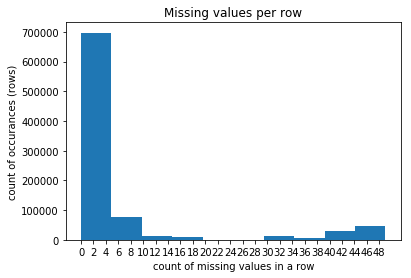

In [10]:
# How much data is missing in each row of the dataset?

'''
row_missing_vals = {} # row id => missing values
for index, row in azdias_clean_v2.iterrows():
    row_vals = row.value_counts(dropna=False)
    if np.NaN not in row_vals:
        row_missing_vals[index] = 0
    else:
        row_missing_vals[index] = row_vals[np.NaN]
    print("[DEBUG] row {r} has {n} missing values". format(r=index, n=row_missing_vals[index]))
'''

# Better way, ref: https://stackoverflow.com/questions/30059260/python-pandas-counting-the-number-of-missing-nan-in-each-row
row_nans = azdias_clean_v2.isnull().sum(axis=1)

# Show histogram on row NaN count
fig, ax = plt.subplots()
ax.hist(row_nans)
ax.xaxis.set_ticks(np.arange(0, 50, 2.0))
plt.ylabel("count of occurances (rows)")
plt.xlabel("count of missing values in a row")
plt.title("Missing values per row")
plt.show()

In [11]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# From the histogram above, it looks like the vast data can be split at 10 (or 5 if we want to be more aggressive)
threshold=10

''' Old / inefficient code: 
# Split azdias_clean_v2 into 'clean' and 'dirty' sub-sets based on missing values threshold
# Note: there is prob a more efficient way to do this - investigate if there is enough time
# This takes awhile to run!
v2_clean_dict = {}
v2_clean_idx = 0
v2_dirty_dict = {}
v2_dirty_idx = 0
for index, row in azdias_clean_v2.iterrows():
    row_vals = row.value_counts(dropna=False)
    #print("[DEBUG] row vals: ", row_vals)
    missing_cnt = row_vals.loc[row_vals.index.isnull()].tolist()
    #print("[DEBUG] missing_cnt: ", missing_cnt)
    if len(missing_cnt) > 0:
        if missing_cnt[0] >= threshold:
            #print("[DEBUG] ", index, " is a dirty row so drop from clean df")
            #v2_clean = v2_clean.drop(v2_clean.index[index])
            v2_dirty_dict[v2_dirty_idx] = row
            v2_dirty_idx += 1
        else:
            #print("[DEBUG] ", index, " is a clean row so drop from dirty df")
            #v2_dirty = v2_dirty.drop(v2_dirty.index[index])
            v2_clean_dict[v2_clean_idx] = row
            v2_clean_idx += 1
    else:
        #print("[DEBUG] ", index, " is a clean row so drop from dirty df")
        #v2_dirty = v2_dirty.drop(v2_dirty.index[index])
        v2_clean_dict[v2_clean_idx] = row
        v2_clean_idx += 1

v2_clean = pd.DataFrame.from_dict(v2_clean_dict).transpose()    
v2_dirty = pd.DataFrame.from_dict(v2_dirty_dict).transpose()

'''

        
thresh = azdias_clean_v2.shape[1] - threshold
v2_clean = azdias_clean_v2.dropna(axis=0, how='any', thresh=thresh)
# Ref: https://stackoverflow.com/questions/37313691/how-to-remove-a-pandas-dataframe-from-another-dataframe
v2_dirty = pd.concat([azdias_clean_v2, v2_clean]).drop_duplicates(keep=False)
print("Clean shape: ", v2_clean.shape)
print("Dirty shape: ", v2_dirty.shape)
v2_dirty.head()

Clean shape:  (780153, 79)
Dirty shape:  (55288, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,3.0,1,3.0,5,2,4,2,3,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,5.0
30,3.0,2,3.0,4,3,4,4,4,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,2.0,2,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,NaN,2,3.0,2,4,3,5,5,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

compare_candidates = []
for col in v2_dirty:
    #print("[DEBUG] col: ", col)
    dirty_col_vals = v2_dirty[col].value_counts(dropna=False)
    #print("[DEBUG] dirty_col_vals: ", dirty_col_vals)
    clean_col_vals = v2_clean[col].value_counts(dropna=False)
    
    dirty_missing_cnt = dirty_col_vals.loc[dirty_col_vals.index.isnull()].tolist()
    #print("[DEBUG] dirty_missing_cnt: ", dirty_missing_cnt)
    clean_missing_cnt = clean_col_vals.loc[clean_col_vals.index.isnull()].tolist()
    
    if (len(dirty_missing_cnt)==0 and len(clean_missing_cnt)==0):
        compare_candidates.append(col)
    
print(compare_candidates)

['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP']


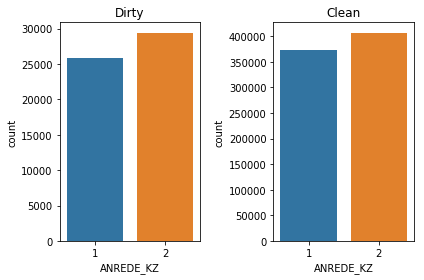

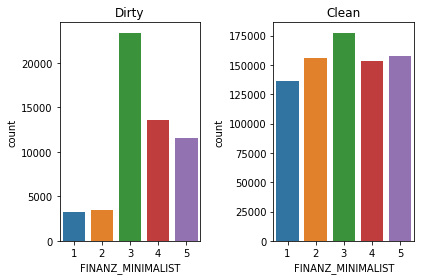

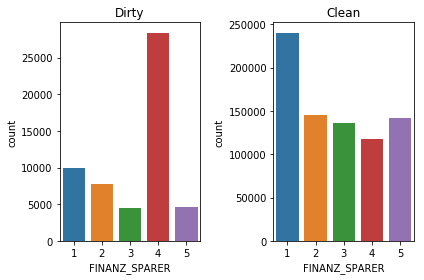

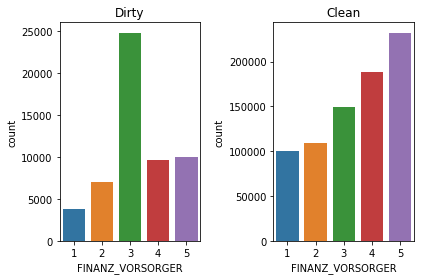

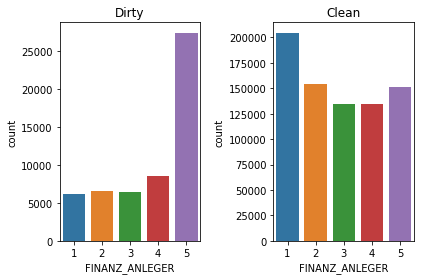

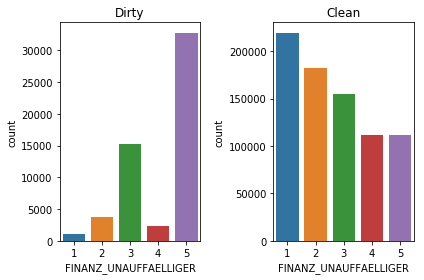

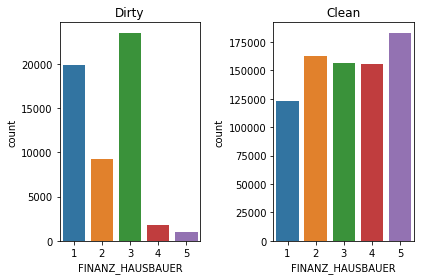

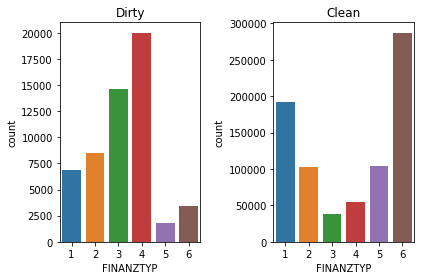

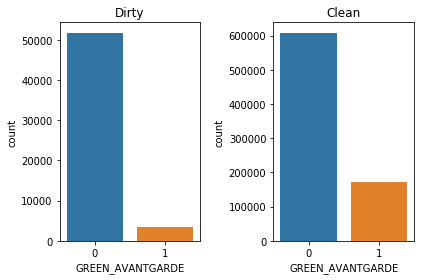

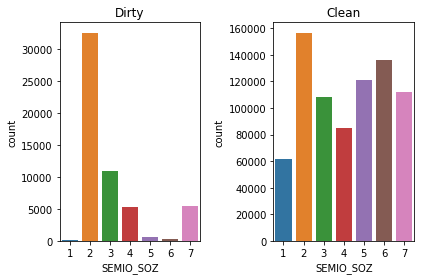

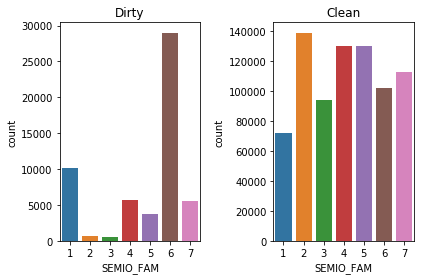

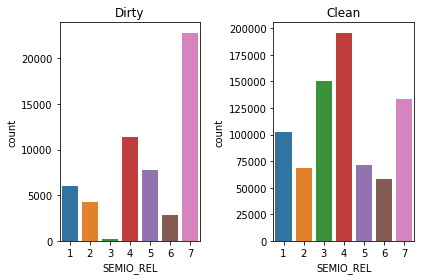

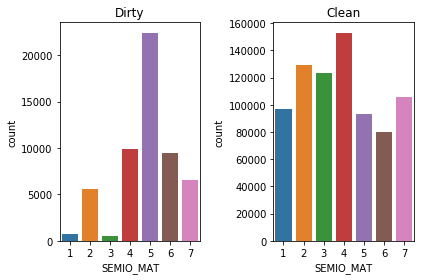

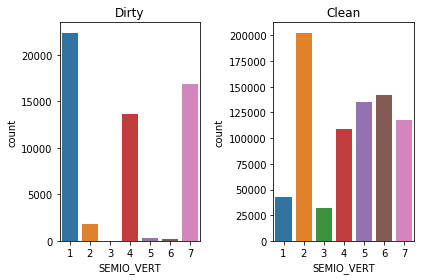

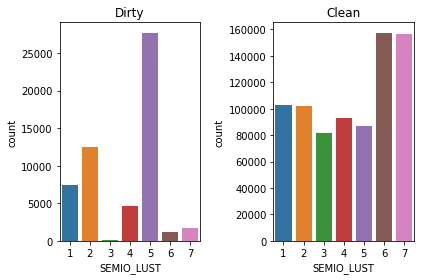

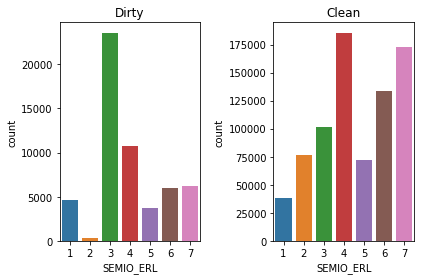

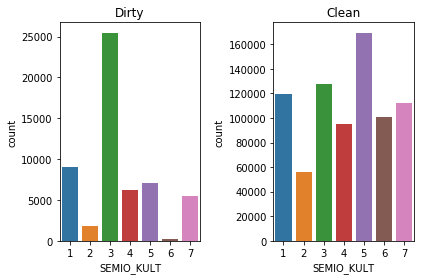

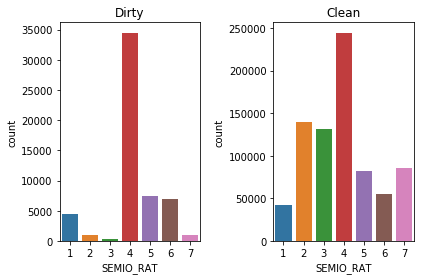

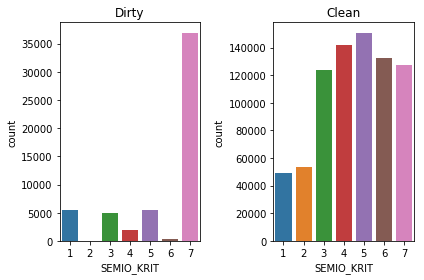

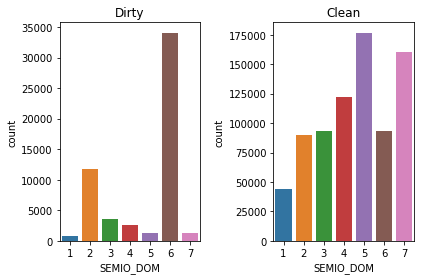

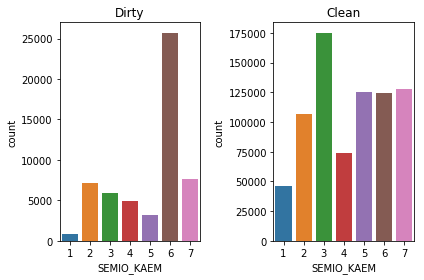

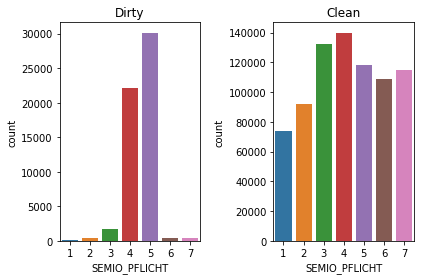

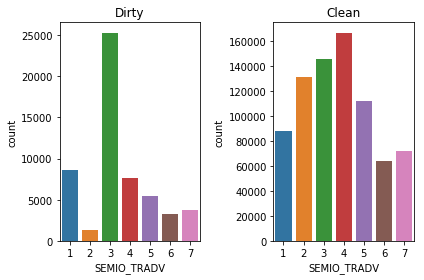

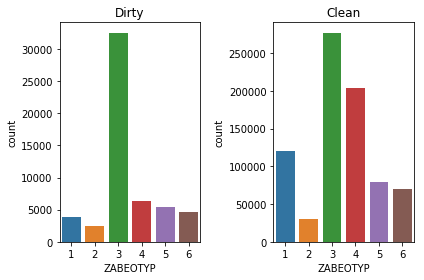

In [13]:
# For each candidate feature display the value distribution b/t the v2_dirty and v2_clean dataframes
# This is to identify if the feature values are similar b/t the two groups
# Use seaborn's countplot() function to create a bar chart of code frequencies 
# and matplotlib's subplot() function to put bar charts for the two subplots side by side.

# Loop through and display charts in twos - this is more readable than when I tried
# to jam all of the subplots into one figure

# Supress the warnings - removed show/close statements to display in notebook
plt.rcParams.update({'figure.max_open_warning': 0})

for cc in (compare_candidates):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.set_title("Dirty")
    ax2.set_title("Clean")
    sns.countplot(x=cc, data=v2_dirty, ax=ax1)
    sns.countplot(x=cc, data=v2_clean, ax=ax2)
    fig.tight_layout()
    #fig.show()
    #plt.close(fig)


#### Discussion 1.1.3: Assess Missing Data in Each Row


When I split the data with the above threshold (10) of missing row data - if we wanted to be more aggressive in our dropping of rows, 5 could have also been used as a threshold (looking for "elbow"). I called the set of data meeting the threshold of missing row values as "dirty" and the set of data with less than threshold missing row values as "clean". There were 24 columns (features) between both data sets ("dirty" and "clean") that did not have any missing values. Upon ploting and inspecting the distribution of the feature values between each data set, I see that the "dirty" data set often exhibits a very dominant value for the feature, whereas the "clean" data set has a more normal (Gaussian) distribution. It is possible that there is a particular type/class of person that has a number of missing features - and since this data split effectively grouped them into the "dirty" data set, they share a number of common feature values. Note too: these could be "default" values at data collection time and since we already know that the "dirty" data has many missing values there could be other features that have default values or are pre-populated during the data collection. In any case, there is less qualitative value in the dirty data set and could negatively influence our clustering in the future. Looking further into the meaning of these features- many of these are financial attitudes (FINANZ) and personalities (SEMIO) -- these dominant attitudes/personality values within 'dirty' must correlate to lack of data for other features either through omission or because they typically have sparse features.

Below provides a list of the observations for each feature (e.g., the dominant value):

* ANREDE_KZ - similar plots
* FINANZ_MINIMALIST - value 3 is dominant in dirty
* FINANZ_SPARER - value 4 is dominant in dirty
* FINANZ_VORSORGER - value 3 is dominant in dirty
* FINANZ_ANLEGER - value 5 is dominant in dirty
* FINANZ_UNAUFFAELLIGER - value 5 is dominant in dirty
* FINANZ_HAUSBAUER - value 3 is dominant in dirty
* FINANZTYP - value 4 is dominant in dirt, value 6 is top in clean
* GREEN_ADVANTAGE - similar plots
* SEMIO_SOZ - value 2 is dominant in dirty
* SEMIO_FAM - value 6 is dominant in dirty
* SEMIO_REL - value 7 is dominant in dirty
* SEMIO_MAT - value 5 is dominant in dirty
* SEMIO_VERT - value 1 is dominant in dirty
* SEMIO_LUST - value 5 is dominant in dirty
* SEMIO_ERL - value 3 is dominant in dirty
* SEMIO_KULT - value 3 is dominant in dirty
* SEMIO_RAT - value 4 is dominant in dirty and fairly dominant in clean
* SEMIO_KRIT - value 7 is dominant in dirty
* SEMIO_DOM - value 6 is dominant in dirty
* SEMIO_KAEM - value 6 is dominant in dirty
* SEMIO_PFLICHT - value 5 is dominant in dirty
* SEMIO_TRADV - value 3 is dominant in dirty 
* ZABEOTYP - value 3 is dominant dirty and the top value in clean

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [14]:
# How many features are there of each data type?

feat_info['type'].value_counts(dropna=False)

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [15]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cats = feat_info.query('type == "categorical"')['attribute']

numeric_binaries = []
binaries_features_to_encode = []
multi_features_to_encode = []

for c in cats:
    if c in v2_clean:  # Needed b/c we removed some features
        vals = v2_clean[c].value_counts(dropna=False).index.values.tolist()
        if (len(vals)==2):
            # Check if all the values are numeric
            numeric = True
            for i in vals:
                if isinstance(i, str):
                    numeric = False
                    
            if numeric:
                #print("[DEBUG] ", c, " : Numeric Binary (nothing more to do).")
                numeric_binaries.append(c)
            else:
                #print("[DEBUG] ", c, " : Non-Numeric Binary (need to encode).")
                binaries_features_to_encode.append(c)
            #print("[DEBUG] Displaying values: ")
            #print(vals)
        elif (len(vals) > 2):
            multi_features_to_encode.append(c)
            # Multi-level
            #print(c, " : Multi-level")
            #print("    ", vals)

            
print("Numeric binary features (not needing encoding): ", numeric_binaries)
print("Non-Numeric binary features needing encoding: ", binaries_features_to_encode)
print("Multi-level fetures to encode: ", multi_features_to_encode)

Numeric binary features (not needing encoding):  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ']
Non-Numeric binary features needing encoding:  ['OST_WEST_KZ']
Multi-level fetures to encode:  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [16]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Note: good reference page: http://pbpython.com/categorical-encoding.html

# Save previous dataframe in case I screw up the encoding and need to backtrack
v3_clean = v2_clean.copy()

# Encode non-numeric binary features
bin_encoder = {}
for bin_attrib in binaries_features_to_encode:
    if bin_attrib in v3_clean:
        vals = v3_clean[bin_attrib].value_counts(dropna=False).index.values.tolist()
        bin_encoder[bin_attrib] = { vals[0]:0, vals[1]:1 }
v3_clean.replace(bin_encoder, inplace=True)

# Multi-level features
# Based on the instructions above "to keep things straightforward" I'll drop them from analysis
# I can always circle back to this cell and make things more complex, adding in the one hot encoding logic
print("[DEBUG] ", v3_clean.shape)
for ml_attrib in multi_features_to_encode:
    if ml_attrib in v3_clean:
        print("[DEBUG] dropping ", ml_attrib)
        v3_clean = v3_clean.drop(ml_attrib, axis=1)
print("[DEBUG] ", v3_clean.shape)

[DEBUG]  (780153, 79)
[DEBUG] dropping  CJT_GESAMTTYP
[DEBUG] dropping  FINANZTYP
[DEBUG] dropping  GFK_URLAUBERTYP
[DEBUG] dropping  LP_FAMILIE_FEIN
[DEBUG] dropping  LP_FAMILIE_GROB
[DEBUG] dropping  LP_STATUS_FEIN
[DEBUG] dropping  LP_STATUS_GROB
[DEBUG] dropping  NATIONALITAET_KZ
[DEBUG] dropping  SHOPPER_TYP
[DEBUG] dropping  VERS_TYP
[DEBUG] dropping  ZABEOTYP
[DEBUG] dropping  GEBAEUDETYP
[DEBUG] dropping  CAMEO_DEUG_2015
[DEBUG] dropping  CAMEO_DEU_2015
[DEBUG]  (780153, 65)


#### Discussion 1.2.1: Re-Encode Categorical Features

I kept the binary/numeric categorical features:
Numeric binary features (not needing encoding):  'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ'

I encoded the non-numeric binary feature:
Non-Numeric binary features needing encoding:  'OST_WEST_KZ'

And I dropped the multi-level features:
Multi-level fetures to encode:  'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'

The decision to drop the multi-level features was 2-fold: (1) the dataset is already feature rich with many overlapping/duplicative features, and (2) per the instructions it was stated to keep things simply, these features could be dropped. I'm of the mindset, that initially we should keep our methodology/methods simple to start- I can always circle back around to this step and one-hot encode/include these features if desired to see how they impact the clustering.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [17]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Copied in from Data_Dictionary.md for reference
'''
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
'''

mainstream = 0
avantgarde = 1
mapping_dict = {
    1.0 : [40, mainstream],
    2.0 : [40, avantgarde],
    3.0 : [50, mainstream],
    4.0 : [50, avantgarde],
    5.0 : [60, mainstream],
    6.0 : [60, avantgarde],
    7.0 : [60, avantgarde],
    8.0 : [70, mainstream],
    9.0 : [70, avantgarde],
    10.0 : [80, mainstream],
    11.0 : [80, avantgarde],
    12.0 : [80, mainstream],
    13.0 : [80, avantgarde],
    14.0 : [90, mainstream],
    15.0 : [90, avantgarde]
}

decade = []
movement = []
for val in v3_clean["PRAEGENDE_JUGENDJAHRE"]:
    if np.isnan(val):
        decade.append(np.NaN)
        movement.append(np.NaN)
    elif val in mapping_dict:
        mapping = mapping_dict[val]
        decade.append(mapping[0])
        movement.append(mapping[1])
    else:
        print("Error unhandled case: ", val)


# Add 'decade' feature to v3_clean dataframe
v3_clean = v3_clean.assign(decade=decade)

# Add 'movement' feature to v3_clean dataframe
v3_clean = v3_clean.assign(movement=movement)

# check one
v3_clean['decade'].value_counts(dropna=False)

 90.0    219439
 70.0    171875
 80.0    148118
 60.0    113126
 50.0     73441
 40.0     27680
NaN       26474
Name: decade, dtype: int64

In [18]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

#print(v3_clean["CAMEO_INTL_2015"].value_counts(dropna=False))

wealth = [] # tens place
lifestage = [] # ones place
for val in v3_clean["CAMEO_INTL_2015"]:
    try:
        # Split val into 10s and 1s place
        vals = list(str(val))
        wealth.append(int(vals[0]))
        lifestage.append(int(vals[1]))
    except:
        wealth.append(np.NaN)
        lifestage.append(np.NaN)

# Add 'wealth' feature to v3_clean dataframe
v3_clean = v3_clean.assign(wealth=wealth)

# Add 'lifestage' feature to v3_clean dataframe
v3_clean = v3_clean.assign(lifestage=lifestage)

# check one
v3_clean['wealth'].value_counts(dropna=False)


 5.0    221854
 4.0    187271
 2.0    184575
 1.0    116706
 3.0     66091
NaN       3656
Name: wealth, dtype: int64

In [19]:

# For the moment drop all mixed-type features
# Note: we can drop "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" as well since we created new sub-features from them
mixeds = feat_info.query('type == "mixed"')['attribute']

print("[DEBUG] ", v3_clean.shape)
for m in mixeds:
    if m in v3_clean:
        print("[DEBUG] dropping ", m)
        v3_clean = v3_clean.drop(m, axis=1)
print("[DEBUG] ", v3_clean.shape)

[DEBUG]  (780153, 69)
[DEBUG] dropping  LP_LEBENSPHASE_FEIN
[DEBUG] dropping  LP_LEBENSPHASE_GROB
[DEBUG] dropping  PRAEGENDE_JUGENDJAHRE
[DEBUG] dropping  WOHNLAGE
[DEBUG] dropping  CAMEO_INTL_2015
[DEBUG] dropping  PLZ8_BAUMAX
[DEBUG]  (780153, 63)


#### Discussion 1.2.2: Engineer Mixed-Type Features

For the moment, to keep things simple and test/verify my current work I am opt'ing NOT to keep any other mixed features besides the features engineered from the two specifically mentioned (PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015). The dataset is feature rich, and there are only a few mixed features remaining - of which appear to overlap with other features.

I'm dropping/ignoring these mixed features:
LP_LEBENSPHASE_FEIN (life stage, fine scale)
LP_LEBENSPHASE_GROB (life stage, rough scale)
WOHNLAGE (neighborhood quality/rural)
PLZ8_BAUMAX (most common building type in region)

The first two are a blended mix of household/family, earnings, and age -- many of these features are captured in other features (FINANZ, FAMILIE, and the earlier wealth and decade features that I already engineered).


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [20]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# spot check
for col in v3_clean:
    #print("[DEBUG] col: ", col)
    col_vals = v3_clean[col].value_counts(dropna=False)
    print(col, " : ")
    print(col_vals)


ALTERSKATEGORIE_GROB  : 
 3.0    302755
 4.0    219520
 2.0    133753
 1.0    121500
NaN       2625
Name: ALTERSKATEGORIE_GROB, dtype: int64
ANREDE_KZ  : 
2    406643
1    373510
Name: ANREDE_KZ, dtype: int64
FINANZ_MINIMALIST  : 
3    177306
5    157192
2    155760
4    153562
1    136333
Name: FINANZ_MINIMALIST, dtype: int64
FINANZ_SPARER  : 
1    240169
2    145223
5    141650
3    135887
4    117224
Name: FINANZ_SPARER, dtype: int64
FINANZ_VORSORGER  : 
5    232247
4    188525
3    149387
2    109477
1    100517
Name: FINANZ_VORSORGER, dtype: int64
FINANZ_ANLEGER  : 
1    204594
2    154708
5    151412
4    134952
3    134487
Name: FINANZ_ANLEGER, dtype: int64
FINANZ_UNAUFFAELLIGER  : 
1    219513
2    181973
3    155227
5    112100
4    111340
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
FINANZ_HAUSBAUER  : 
5    182958
2    162549
3    156059
4    155391
1    123196
Name: FINANZ_HAUSBAUER, dtype: int64
GREEN_AVANTGARDE  : 
0    608462
1    171691
Name: GREEN_AVANTGARDE, dtype: int64

PLZ8_ANTG2  : 
 3.0    306220
 2.0    214815
 4.0    190626
 1.0     52960
NaN       8115
 0.0      7417
Name: PLZ8_ANTG2, dtype: int64
PLZ8_ANTG3  : 
 2.0    252178
 1.0    236885
 3.0    163774
 0.0    119201
NaN       8115
Name: PLZ8_ANTG3, dtype: int64
PLZ8_ANTG4  : 
 0.0    354879
 1.0    294036
 2.0    123123
NaN       8115
Name: PLZ8_ANTG4, dtype: int64
PLZ8_HHZ  : 
 3.0    308165
 4.0    211288
 5.0    175111
 2.0     66594
 1.0     10880
NaN       8115
Name: PLZ8_HHZ, dtype: int64
PLZ8_GBZ  : 
 3.0    287466
 4.0    179539
 5.0    153163
 2.0    111339
 1.0     40531
NaN       8115
Name: PLZ8_GBZ, dtype: int64
ARBEIT  : 
 4.0    306496
 3.0    249020
 2.0    131427
 1.0     54599
 5.0     34612
NaN       3999
Name: ARBEIT, dtype: int64
ORTSGR_KLS9  : 
 5.0    144718
 4.0    111857
 7.0    101046
 9.0     90303
 3.0     81234
 6.0     74628
 8.0     71839
 2.0     61385
 1.0     39236
NaN       3907
Name: ORTSGR_KLS9, dtype: int64
RELAT_AB  : 
 3.0    268422
 5.0    172215
 1.0

In [21]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Looks good - all numerics

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [2]:
def clean_data(df, feat_info=pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';'), verbose=False):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    ####
    # verbose display
    def verbose_display(df):
        print("[Verbose] DataFrame info: ")
        print(df.shape)
        #print(df.describe())
        print(df.head())
    
    ####
    # convert missing value codes into NaNs
    def missing_to_nan(df, feat_info):
        # Create a dict for attribute's bad data values
        bad_data_dict = dict(zip(feat_info['attribute'], feat_info['missing_or_unknown']))

        # Loop through dict because we need to correct the string/integer problem it has in the list
        # Note: there is probably an easier/more eloquant way to do this (come back and research if I have time)
        for attrib, bad_data in bad_data_dict.items():
            bad_data = bad_data.strip('[]')
            bad_data_fixed = []
            for bad_data_item in bad_data.split(","):
                try:
                    bad_data_fixed.append(int(bad_data_item))
                except ValueError:
                    bad_data_fixed.append(str(bad_data_item))
            bad_data_dict[attrib] = bad_data_fixed

        # Replace the bad data values with NaN
        print("[*] Replacing missing/unknown values with NaNs")
        nan_df = df.replace(bad_data_dict, np.NaN)
        return nan_df
            
    ####
    # drop sparse columns
    def drop_sparse_cols(df, nan_thresh_pct=0.25):
        # Drop column if >= threshold percent (25% is default) containing NaN (missing) values
        row_cnt = df.shape[0]
        for col in df:
            col_vals = df[col].value_counts(dropna=False)
            try:
                #pct = col_vals.loc[col_vals.index.isnull()]/row_cnt
                pct = col_vals[np.NaN]/row_cnt
                if pct >= nan_thresh_pct:
                    print("[*] Dropping sparse column: {c} ({pct:.2%} missing)".format(c=col, pct=pct))
                    df = df.drop(col, axis=1)
            except:
                continue
        return df
    
    ####
    # drop columns by name -- need this vs drop_sparse_cols for Customer data
    def drop_columns_by_name(df, col_names=['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 
                                            'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']):
        for col in col_names:
            print("[*] Dropping column by name: ", col)
            df = df.drop(col, axis=1)
        return df

    
    ''' Old / inefficient code:
    ####
    # drop sparse rows (actually I'm creating/returning a new df vs. dropping from the original)
    def drop_sparse_rows(df, nan_thresh_cnt=10):
        # Exclude row if >= threshold count (default=10) containing NaN (missing) values
        df2_idx = 0
        df2_dict = {}
        print("[*] Dropping sparse rows...")
        for index, row in df.iterrows():
            row_vals = row.value_counts(dropna=False)
            missing_cnt = row_vals.loc[row_vals.index.isnull()].tolist()
            if len(missing_cnt) > 0:
                if missing_cnt[0] < nan_thresh_cnt:
                    df2_dict[df2_idx] = row
                    df2_idx += 1
                # Commenting this out- too noisey
                #else:
                #    print("[*] Dropping sparse row: ", index)
            else:
                df2_dict[df2_idx] = row
                df2_idx += 1
        df2 = pd.DataFrame.from_dict(df2_dict).transpose()
        print("Done.")
        return df2
    '''
    
    ####
    # Much more efficient way of dropping sparse rows
    def drop_sparse_rows(df, nan_thresh_cnt=10):
        print("[*] Dropping sparse rows...")
        thresh = df.shape[1] - nan_thresh_cnt
        df2 = df.dropna(axis=0, how='any', thresh=thresh)
        print("Done")
        return df2
    
    ####
    # process categorical features (columns)
    def process_categorical_cols(df, feat_info):
        cats = feat_info.query('type == "categorical"')['attribute']
        cat_types = {
            'num_binary' : [],     # Do nothing
            'nonnum_binary' : [],  # Encode
            'multi_level' : []     # Drop (can come back and add OneHotEncode if needed)
        }
        
        # Review categorical features to determine type
        for c in cats:
            if c in df:
                vals = df[c].value_counts(dropna=False).index.values.tolist()
                if (len(vals)==2):  # Binary
                    numeric = True
                    for i in vals:
                        if isinstance(i, str):
                            numeric = False
                    if numeric:
                        cat_types['num_binary'].append(c)
                    else:
                        cat_types['nonnum_binary'].append(c)
                else:  # Multi-Level
                    cat_types['multi_level'].append(c)

        # Encode non-numeric binary features
        bin_encoder = {}
        for bin_feature in cat_types['nonnum_binary']:
            if bin_feature in df:
                vals = df[bin_feature].value_counts(dropna=False).index.values.tolist()
                bin_encoder[bin_feature] = { vals[0]:0, vals[1]:1 } # Use binary 0/1 values
                print("[*] Encoding non-numeric binary categorical feature: ", bin_feature)
        df.replace(bin_encoder, inplace=True)
        
        # Drop multi-level (replace with OneHotEncoding later if needed)
        for ml_feature in cat_types['multi_level']:
            if ml_feature in df:
                print("[*] Dropping multi-level categorical feature: ", ml_feature)
                df = df.drop(ml_feature, axis=1)
        return df
    
    ####
    # process mixed features (columns)
    def process_mixed_cols(df, feat_info):
        
        ########
        ## PRAEGENDE_JUGENDJAHRE_processor
        def PRAEGENDE_JUGENDJAHRE_processor(df):
            # Mapping for mixed feature
            mainstream = 0
            avantgarde = 1
            mapping_dict = {
                1.0 : [40, mainstream],
                2.0 : [40, avantgarde],
                3.0 : [50, mainstream],
                4.0 : [50, avantgarde],
                5.0 : [60, mainstream],
                6.0 : [60, avantgarde],
                7.0 : [60, avantgarde],
                8.0 : [70, mainstream],
                9.0 : [70, avantgarde],
                10.0 : [80, mainstream],
                11.0 : [80, avantgarde],
                12.0 : [80, mainstream],
                13.0 : [80, avantgarde],
                14.0 : [90, mainstream],
                15.0 : [90, avantgarde] }

            decade = []
            movement = []
            for val in df["PRAEGENDE_JUGENDJAHRE"]:
                if np.isnan(val):
                    decade.append(np.NaN)
                    movement.append(np.NaN)
                elif val in mapping_dict:
                    mapping = mapping_dict[val]
                    decade.append(mapping[0])
                    movement.append(mapping[1])
                else:
                    print("[WARN] unexpected PRAEGENDE_JUGENDJAHRE value: ", val)

            # Add 'decade' feature to dataframe
            print("[*] Adding decade feature from PRAEGENDE_JUGENDJAHRE mixed feature")
            df = df.assign(decade=decade)

            # Add 'movement' feature to dataframe
            print("[*] Adding movement feature from PRAEGENDE_JUGENDJAHRE mixed feature")
            df = df.assign(movement=movement)
            return df
          
        ########
        ## CAMEO_INTL_2015_processor
        def CAMEO_INTL_2015_processor(df):
            wealth = [] # tens place
            lifestage = [] # ones place
            for val in df["CAMEO_INTL_2015"]:
                try:
                    # Split val into 10s and 1s place
                    vals = list(str(val))
                    wealth.append(int(vals[0]))
                    lifestage.append(int(vals[1]))
                except:
                    wealth.append(np.NaN)
                    lifestage.append(np.NaN)

            # Add 'wealth' feature to dataframe
            print("[*] Adding wealth feature from CAMEO_INTL_2015 mixed feature")
            df = df.assign(wealth=wealth)

            # Add 'lifestage' feature to dataframe
            print("[*] Adding lifestage feature from CAMEO_INTL_2015 mixed feature")
            df = df.assign(lifestage=lifestage)
            return df
            
        ########
        ## main process_mixed_cols() logic
        mixs = feat_info.query('type == "mixed"')['attribute']
        for m in mixs:
            if m in df:
                if m == "PRAEGENDE_JUGENDJAHRE":
                    # Process PJ
                    df = PRAEGENDE_JUGENDJAHRE_processor(df)
                    # Drop PJ since we engineered features from it already
                    print("[*] Dropping mixed feature: ", m)
                    df = df.drop(m, axis=1)
                elif m == "CAMEO_INTL_2015":
                    # Process C2015
                    df = CAMEO_INTL_2015_processor(df)
                    # Drop C2015 since we engineered features from it already
                    print("[*] Dropping mixed feature: ", m)
                    df = df.drop(m, axis=1)
                else:
                    # Drop mixed features we don't have a processor for
                    print("[*] Dropping mixed feature: ", m)
                    df = df.drop(m, axis=1)
        return df
    
    ####
    # main clean_data() logic
    if verbose: verbose_display(df) 
    df = missing_to_nan(df, feat_info)
    if verbose: verbose_display(df)
    #df = drop_sparse_cols(df)
    # Dropping columns by name vs. threshold to ensure same shape for Customers data
    df = drop_columns_by_name(df)
    if verbose: verbose_display(df)
    df = drop_sparse_rows(df)
    if verbose: verbose_display(df)
    df = process_categorical_cols(df, feat_info)
    if verbose: verbose_display(df)
    df = process_mixed_cols(df, feat_info)
    if verbose: verbose_display(df)
    return df

In [3]:
# Do re-loading of data in-case I ever muck with the original dataframes above
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

# Cleaned DF
clean_df = clean_data(azdias, feat_info, True)

# Use clean_df for remaining of project

[Verbose] DataFrame info: 
(891221, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            N

[*] Dropping multi-level categorical feature:  GFK_URLAUBERTYP
[*] Dropping multi-level categorical feature:  LP_FAMILIE_FEIN
[*] Dropping multi-level categorical feature:  LP_FAMILIE_GROB
[*] Dropping multi-level categorical feature:  LP_STATUS_FEIN
[*] Dropping multi-level categorical feature:  LP_STATUS_GROB
[*] Dropping multi-level categorical feature:  NATIONALITAET_KZ
[*] Dropping multi-level categorical feature:  SHOPPER_TYP
[*] Dropping multi-level categorical feature:  VERS_TYP
[*] Dropping multi-level categorical feature:  ZABEOTYP
[*] Dropping multi-level categorical feature:  GEBAEUDETYP
[*] Dropping multi-level categorical feature:  CAMEO_DEUG_2015
[*] Dropping multi-level categorical feature:  CAMEO_DEU_2015
[Verbose] DataFrame info: 
(780153, 65)
   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                   1.0          2                  1              5   
2                   3.0          2                  1              4   
3           

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [4]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

print("NaNs:")
print(clean_df.isnull().sum())
# Note: from this it is apparent that there is still a lot of NaNs
# I think we'd be removing a lot of data if we just removed them
# So, using an imputer to replace NaNs with the mean- the problem is 
# this imputation can distort the feature's distribution and its relationships
# Use imputer for the time being, but TODO: think of another strategy 

from sklearn.preprocessing import Imputer
# Ref: https://docs.featuretools.com/examples/customer_segmentation.html
fill_NaN = Imputer(missing_values=np.NaN, strategy='mean', axis=0)
imputed_df = pd.DataFrame(fill_NaN.fit_transform(clean_df))
imputed_df.columns = clean_df.columns
imputed_df.index = clean_df.index

print("Data before Imputer: ")
print(clean_df.describe())
print("Mean Imputed data: ")
print(imputed_df.describe())

NaNs:
ALTERSKATEGORIE_GROB      2625
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP               34524
RETOURTYP_BK_S            3834
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
ANZ_PERSONEN                 0
ANZ_TITEL                    0
HH_EINKOMMEN_SCORE           0
W_KEIT_KIND_HH           56282
                         ...  
KONSUMNAEHE                 51
MI

In [5]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(imputed_df))
scaled_df.columns = clean_df.columns
scaled_df.index = clean_df.index

print("Scaled data: ")
print(scaled_df.describe())

Scaled data: 
       ALTERSKATEGORIE_GROB     ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count          7.801530e+05  7.801530e+05       7.801530e+05   7.801530e+05   
mean          -7.685107e-17  4.519714e-17       1.012780e-16   7.527544e-17   
std            1.000001e+00  1.000001e+00       1.000001e+00   1.000001e+00   
min           -1.767099e+00 -1.043411e+00      -1.488140e+00  -1.151087e+00   
25%           -7.841642e-01 -1.043411e+00      -7.624505e-01  -1.151087e+00   
50%            1.987707e-01  9.583948e-01      -3.676105e-02   1.939963e-01   
75%            1.181706e+00  9.583948e-01       6.889284e-01   8.665379e-01   
max            1.181706e+00  9.583948e-01       1.414618e+00   1.539080e+00   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count      7.801530e+05    7.801530e+05           7.801530e+05   
mean       8.963834e-17    1.339657e-16           9.701560e-17   
std        1.000001e+00    1.000001e+00           1.000001e+00   
min       

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

From above, I noticed that there are a lot of NaNs for a number of the features (10s of thousands in several cases). It is possible that we would lose a lot of our training set if we simply removed records with NaNs. So I considered using an Imputer to replace NaNs with the mean for each feature. This is an 'ok' choice- but the problem could arise that this imputation could distort the feature's distribution and its relationships to other features. I've kept the imputer for the time being, but depending on time I might try / think of another strategy (e.g., maybe a binary 'NaN' feature for each feature  with some threshold value of NaNs to indicate if the feature value was a NaN or not). Given time on this project I'm going to move forward and circle back as time allows to explore better imputer/scaling strategies to deal with the NaNs.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [6]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_df)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [7]:
# Investigate the variance accounted for by each principal component.
print("Components: ", pca.components_)
print("Variance: ", pca.explained_variance_)
print("Ratio: ", pca.explained_variance_ratio_)
print("Singular: ", pca.singular_values_)


Components:  [[ -1.17493296e-01   7.98307518e-03  -2.18908401e-01 ...,  -1.08034900e-01
    2.07642988e-01  -1.25323802e-01]
 [  2.60588882e-01   9.05911989e-02   6.77861735e-02 ...,  -1.27109207e-02
    7.25568269e-02   2.42254395e-03]
 [  7.91823636e-02  -3.68757272e-01   1.56226384e-01 ...,   4.63347173e-02
    2.73381832e-02  -8.92633406e-03]
 ..., 
 [ -6.90858277e-02   1.51580541e-02   2.22153972e-01 ...,   1.01641387e-03
    6.34922113e-03   5.62901510e-03]
 [ -2.94609255e-01  -8.16153826e-01  -4.43645897e-02 ...,  -5.39028367e-04
    1.92212669e-03  -4.14884120e-03]
 [ -4.21445564e-02  -5.32509777e-03  -1.29829583e-03 ...,   7.03969699e-01
   -1.35352919e-03  -2.20241405e-03]]
Variance:  [  1.08344574e+01   8.61299692e+00   6.05180121e+00   3.37976882e+00
   2.41876798e+00   2.03627612e+00   1.76411963e+00   1.57916092e+00
   1.38609956e+00   1.34149888e+00   1.28582959e+00   1.20551493e+00
   1.13456487e+00   1.11163400e+00   1.05058607e+00   1.01484880e+00
   9.99464888e-01   

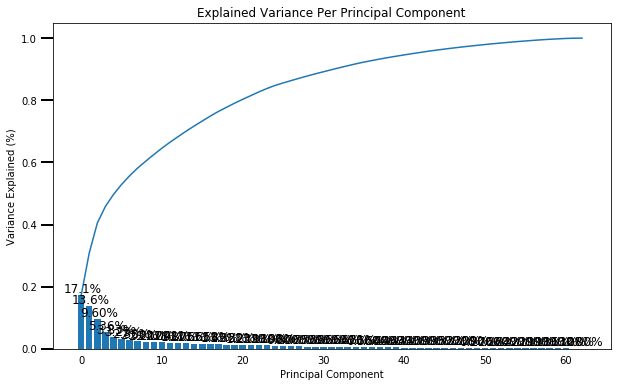

In [8]:
# Function from Udacity lecture
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

Text(0,0.5,'Value Gain')

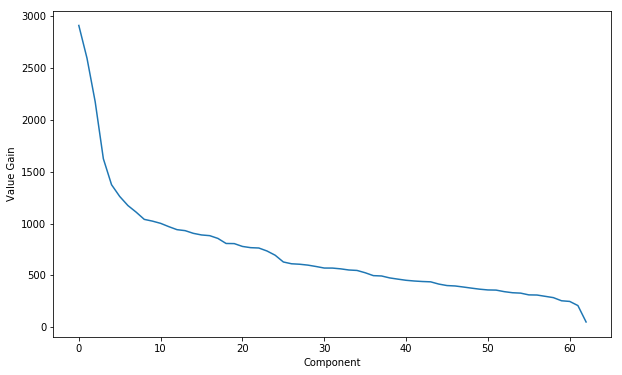

In [9]:
# Taking another view from the singular value decomposition
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
ind = np.arange(len(pca.singular_values_))
vals = pca.singular_values_
ax.plot(ind, vals)
ax.set_xlabel("Component")
ax.set_ylabel("Value Gain")

In [10]:
# Re-apply PCA to the data while selecting for number of components to retain.

# It looks like there are diminishing returns after about 8 components
n_components = 8
pca = PCA(n_components)
reduced_data = pca.fit_transform(scaled_df)
reduced_data.shape

(780153, 8)

### Discussion 2.2: Perform Dimensionality Reduction

When looking at the explained variance increase with additional principal components as well as the value gain per principal component, there was a point reached where value (explained variance) was noticeable less with the addition of each new component. I am estimating this to be around 8 components- which explains ~60% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [11]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pca_weights = pd.DataFrame(pca.components_,columns=scaled_df.columns,index = np.arange(len(pca.components_)))

def comp_weights(pca_weights=pca_weights, component=0):
    weights = pca_weights.iloc[component].sort_values(ascending=False)
    print(weights)

comp_weights(pca_weights, 0)

PLZ8_ANTG3               0.226720
PLZ8_ANTG4               0.219887
wealth                   0.207643
HH_EINKOMMEN_SCORE       0.204340
ORTSGR_KLS9              0.197355
EWDICHTE                 0.195543
FINANZ_HAUSBAUER         0.163027
PLZ8_ANTG2               0.154226
KBA05_ANTG4              0.153061
FINANZ_SPARER            0.144707
ARBEIT                   0.143826
ANZ_HAUSHALTE_AKTIV      0.135797
KBA05_ANTG3              0.135512
RELAT_AB                 0.135503
SEMIO_PFLICHT            0.113421
SEMIO_REL                0.110654
decade                   0.099842
SEMIO_RAT                0.093495
SEMIO_TRADV              0.086917
SEMIO_MAT                0.078481
SEMIO_FAM                0.076692
FINANZ_UNAUFFAELLIGER    0.073217
REGIOTYP                 0.073084
SEMIO_KULT               0.070922
FINANZ_ANLEGER           0.067815
OST_WEST_KZ              0.053981
KKK                      0.044037
SEMIO_SOZ                0.041753
PLZ8_HHZ                 0.041588
SEMIO_KAEM    

In [12]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp_weights(pca_weights, 1)

ALTERSKATEGORIE_GROB     0.260589
FINANZ_VORSORGER         0.232867
SEMIO_ERL                0.231073
SEMIO_LUST               0.183062
RETOURTYP_BK_S           0.163984
W_KEIT_KIND_HH           0.118584
SEMIO_KRIT               0.116393
FINANZ_HAUSBAUER         0.115454
SEMIO_KAEM               0.112063
PLZ8_ANTG3               0.091825
ANREDE_KZ                0.090590
EWDICHTE                 0.090040
ORTSGR_KLS9              0.088683
PLZ8_ANTG4               0.087677
wealth                   0.072560
SEMIO_DOM                0.069556
KBA05_ANTG4              0.067921
FINANZ_MINIMALIST        0.067785
ARBEIT                   0.065934
RELAT_AB                 0.063527
PLZ8_ANTG2               0.063236
ANZ_HAUSHALTE_AKTIV      0.061485
WOHNDAUER_2008           0.059627
HH_EINKOMMEN_SCORE       0.053291
KBA05_ANTG3              0.042138
ANZ_HH_TITEL             0.030675
OST_WEST_KZ              0.025262
REGIOTYP                 0.021305
PLZ8_HHZ                 0.012601
ANZ_TITEL     

In [13]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp_weights(pca_weights, 2)

SEMIO_VERT               0.346296
SEMIO_SOZ                0.263173
SEMIO_FAM                0.250020
SEMIO_KULT               0.234116
FINANZ_MINIMALIST        0.156225
RETOURTYP_BK_S           0.108978
FINANZ_VORSORGER         0.100583
W_KEIT_KIND_HH           0.090774
ALTERSKATEGORIE_GROB     0.079202
SEMIO_REL                0.070074
SEMIO_LUST               0.064547
SEMIO_MAT                0.055360
GREEN_AVANTGARDE         0.048191
ORTSGR_KLS9              0.047018
EWDICHTE                 0.046443
movement                 0.046313
PLZ8_ANTG4               0.045971
PLZ8_ANTG3               0.045574
ARBEIT                   0.034780
WOHNDAUER_2008           0.032921
RELAT_AB                 0.031742
PLZ8_ANTG2               0.030378
KBA05_ANTG4              0.027352
wealth                   0.027340
ANZ_HAUSHALTE_AKTIV      0.025577
OST_WEST_KZ              0.015268
ANZ_HH_TITEL             0.013413
ANZ_TITEL                0.009798
KBA05_ANTG3              0.008079
PLZ8_HHZ      

### Discussion 2.3: Interpret Principal Components

Component 1 provides some correlation insights based on the size of the house/household - for example large family homes are grouped together and are tiued to high household net income whereas smaller homes and low financial interest are on the other side of the spectrum. The below table provides insight into this relationship when we look at the top positive and negative features.

Component 1 weights:

| Top Positive | Bottom Negative |
|--------------|-----------------|
| PLZ8_ANTG3 (0.226720) - Number of 6-10 family houses in the PLZ8 region | MOBI_REGIO (-0.242210) - Movement patterns |
| PLZ8_ANTG4 (0.219887) - Number of 10+ family houses in the PLZ8 region | PLZ8_ANTG1 (-0.226371) - Number of 1-2 family houses in the PLZ8 region |
| wealth (0.207643) | KBA05_ANTG1 (-0.225761) - Number of 1-2 family houses in the microcell |
| HH_EINKOMMEN_SCORE (0.204340) - Estimated household net income | FINANZ_MINIMALIST (-0.218908) - Low financial interest |
| ORTSGR_KLS9 (0.197355) - Size of community | KBA05_GBZ (-0.217257) - Number of buildings in the microcell |
| EWDICHTE (0.195543) - Density of households per square kilometer | KONSUMNAEHE (-0.168031) - Distance from building to point of sale |


Component 2 provides correlation insights to the personality traits of the person as well as age and finances. For example, social traits such as sensual-minded and event-oriented are on the opposite end of the spectrum of religious, traditional, and dutiful personalities.

Component 2 weights:

| Top Positive | Bottom Negative |
|--------------|-----------------|
| ALTERSKATEGORIE_GROB (0.260589) - Estimated age based on name | SEMIO_REL (-0.255452)  - Religious |
| FINANZ_VORSORGER (0.232867) - Prepared financially | decade (-0.251509) |
| SEMIO_ERL (0.231073) - Event-oriented | FINANZ_SPARER (-0.235968) - Money-saver |
| SEMIO_LUST (0.183062) - Sensual-minded | SEMIO_TRADV  (-0.231303) - Tradional-minded |
| RETOURTYP_BK_S (0.163984) - Return type | SEMIO_PFLICHT (-0.229166) - Dutiful |


Component 3 is a continuation of personality trait correlations with some correlations to who has these personalities based on things like gender or wealth. For example, the social/family/cultural minded folks are on the opposite end of the spectrum from those that are combative/dominant/critical minded.

Component 3 weights:

| Top Positive | Bottom Negative |
|--------------|-----------------|
| SEMIO_VERT (0.346296) - dreamful | ANREDE_KZ (-0.368751)  - Gender |
| SEMIO_SOZ (0.263173) - socially-minded | SEMIO_KAEM (-0.337273) - combative attitude |
| SEMIO_FAM (0.250020) - family-minded | SEMIO_DOM (-0.314053) - dominant-minded |
| SEMIO_KULT (0.234116) - cultural-minded | SEMIO_KRIT (-0.274215) - critical-minded |
| FINANZ_MINIMALIST (0.156225) - low financial interest | SEMIO_RAT (-0.217122) - rational |



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [14]:
# Over a number of different cluster counts...
scores = {}
for k in np.arange(start=2,stop=30,step=2): # Can decerase step to 1 to narrow in

    # run k-means clustering on the data and...
    kmeans = KMeans(k)
    labels = kmeans.fit_predict(reduced_data)
    
    # compute the average within-cluster distances.
    scores[k] = kmeans.score(reduced_data)
    print("K: {k} Score: {s}".format(k=k, s=scores[k]))
    # Note: convert "score" to avg distance to centroid
    

K: 2 Score: -22252704.995882366
K: 4 Score: -17033655.193961896
K: 6 Score: -14422580.623923495
K: 8 Score: -12549904.91257065
K: 10 Score: -11523915.952694884
K: 12 Score: -10799214.985674063
K: 14 Score: -10272690.02275452
K: 16 Score: -9801271.397661874
K: 18 Score: -9404653.9698283
K: 20 Score: -9049754.728005547
K: 22 Score: -8712235.782590203
K: 24 Score: -8456290.452753264
K: 26 Score: -8216693.256836216
K: 28 Score: -8021118.820811818


In [15]:
for k in [3,5,7,9,11,13,15]: 

    # run k-means clustering on the data and...
    kmeans = KMeans(k)
    labels = kmeans.fit_predict(reduced_data)
    
    # compute the average within-cluster distances.
    scores[k] = kmeans.score(reduced_data)
    print("K: {k} Score: {s}".format(k=k, s=scores[k]))

K: 3 Score: -19072025.562128086
K: 5 Score: -15686727.440068072
K: 7 Score: -13396654.854079247
K: 9 Score: -12032285.38090725
K: 11 Score: -11114563.043867081
K: 13 Score: -10506099.781568153
K: 15 Score: -10030525.446739351


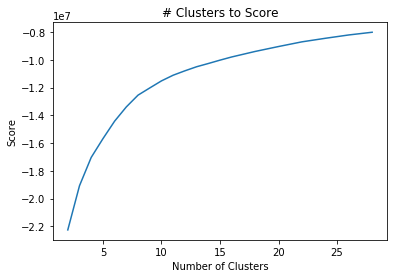

In [16]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

vals = sorted(scores.items())
x, y = zip(*vals)
plt.plot(x, y)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('# Clusters to Score')
plt.show()

In [17]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

optim_k = 10
kmeans = KMeans(optim_k)
genpop_labels = kmeans.fit_predict(reduced_data)

In [18]:
genpop_labels
# Cluster label (0-9) corresponding to reduced_data df row

array([9, 8, 6, ..., 1, 5, 3], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

Using the score() method for kmeans provides an upside down version of the traditional elbow curve (note: we could use absolute values to correct this). While the elbow isn't as dramatic in some of the examples provided in the course lecture, there is still a very noticeable elbow at around point 10, which is what I selected for the optimum K (or number of clusters).

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [19]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,...,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,...,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,4.000000,2.000000
50%,0.000000,3.000000,1.000000,4.000000,4.000000,1.000000,5.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,0.000000,1.000000,3.000000,4.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,6.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


In [20]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Adding "c_" in-front of customer data related variables so I don't get confused/collide

# Clean the data
c_clean_df = clean_data(customers, feat_info, True)
print(c_clean_df.describe())

# Impute the data (fill_NaN Imputer object from above)
# Note: optionally I could define a new Imputer to fit based on customer mean values
# However, from the instructions it seemed that no new sklearn objects should be used in this step
c_imputed_df = pd.DataFrame(fill_NaN.transform(c_clean_df)) # Transform
c_imputed_df.columns = c_clean_df.columns
c_imputed_df.index = c_clean_df.index

# Scale the data (scaler Scale object from above)
c_scaled_df = pd.DataFrame(scaler.transform(c_imputed_df)) # Transform
c_scaled_df.columns = c_clean_df.columns
c_scaled_df.index = c_clean_df.index

# Run PCA to reduce the dimensions (PCA object from above)
c_reduced_data = pca.transform(c_scaled_df) # Transform

# Run KMeans (KMeans object from above)
c_labels = kmeans.predict(c_reduced_data) # Predict
c_labels

[Verbose] DataFrame info: 
(191652, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3

[*] Dropping multi-level categorical feature:  LP_FAMILIE_FEIN
[*] Dropping multi-level categorical feature:  LP_FAMILIE_GROB
[*] Dropping multi-level categorical feature:  LP_STATUS_FEIN
[*] Dropping multi-level categorical feature:  LP_STATUS_GROB
[*] Dropping multi-level categorical feature:  NATIONALITAET_KZ
[*] Dropping multi-level categorical feature:  SHOPPER_TYP
[*] Dropping multi-level categorical feature:  VERS_TYP
[*] Dropping multi-level categorical feature:  ZABEOTYP
[*] Dropping multi-level categorical feature:  GEBAEUDETYP
[*] Dropping multi-level categorical feature:  CAMEO_DEUG_2015
[*] Dropping multi-level categorical feature:  CAMEO_DEU_2015
[Verbose] DataFrame info: 
(139068, 65)
   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   4.0          1                  5              1   
2                   4.0          2                  5              1   
3                   4.0          1                  5              1   
4  

array([0, 8, 3, ..., 0, 6, 3], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


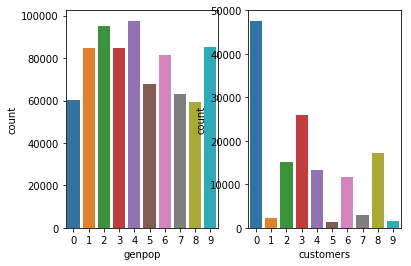

In [21]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# genpop_labels & c_labels vs reduced_data & c_reduced_data
genpop_df = pd.DataFrame({'genpop': genpop_labels})
customer_df = pd.DataFrame({'customers': c_labels})

fig, ax =plt.subplots(1,2)
sns.countplot(genpop_df['genpop'], ax=ax[0])
sns.countplot(customer_df['customers'], ax=ax[1])
fig.show()


{4: 0.13672159015268662, 2: 0.15968775902046983, 9: 0.017900828001505456, 3: 0.30505701945369595, 1: 0.025890960585319801, 6: 0.14191802957594751, 5: 0.021254345136393096, 7: 0.04628440003172337, 0: 0.79030652866242035, 8: 0.28987454444687033}


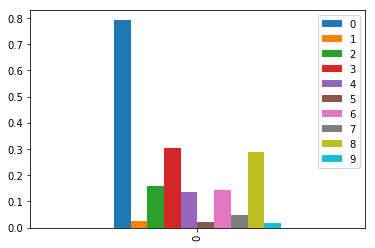

In [22]:
# Show the ratio of customers to genpop for each cluster
genpop_cnts = genpop_df['genpop'].value_counts()
customer_cnts = customer_df['customers'].value_counts()

ratios = {}
for k, v in genpop_cnts.iteritems():
    ratios[k] = customer_cnts[k] / v
    
print(ratios)
pd.DataFrame([ratios]).plot(kind='bar')
plt.show()

In [24]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

customer_cluster_data = pd.DataFrame({'PC0':c_reduced_data[:,0],
                                      'PC1':c_reduced_data[:,1],
                                      'PC2':c_reduced_data[:,2],
                                      'PC3':c_reduced_data[:,3],
                                      'PC4':c_reduced_data[:,4],
                                      'PC5':c_reduced_data[:,5],
                                      'PC6':c_reduced_data[:,6],
                                      'PC7':c_reduced_data[:,7],
                                      'Cluster Label':c_labels
                                     })

#print(customer_cluster_data.describe())


# Cluster 0 is overrepresented in the customer data (about 80% of genpop)
cluster_0 = customer_cluster_data.loc[customer_cluster_data['Cluster Label'] == 0]
print(cluster_0.describe())


# Get cluster 0 centroid
print(kmeans.cluster_centers_[0])



       Cluster Label           PC0           PC1           PC2           PC3  \
count        47646.0  47646.000000  47646.000000  47646.000000  47646.000000   
mean             0.0     -3.647678      0.519641      3.118397      2.472627   
std              0.0      1.513060      1.358637      0.925950      1.136287   
min              0.0     -7.746809     -4.926024     -0.425391     -0.248380   
25%              0.0     -4.777699     -0.318565      2.468784      1.620929   
50%              0.0     -3.801655      0.634650      3.180225      2.461087   
75%              0.0     -2.641654      1.483338      3.822762      3.273783   
max              0.0      2.014554      4.558574      6.261244      9.410824   

                PC4           PC5           PC6           PC7  
count  47646.000000  47646.000000  47646.000000  47646.000000  
mean       0.155510     -0.024280     -0.048698      0.017204  
std        1.410597      0.915158      1.505168      1.122198  
min       -5.602923    

In [25]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Clusters 1, 5, and 9 are underrepresented
print("Cluster 1:")
cluster_1 = customer_cluster_data.loc[customer_cluster_data['Cluster Label'] == 1]
print(cluster_1.describe())
print(kmeans.cluster_centers_[1])

print("Cluster 5:")
cluster_5 = customer_cluster_data.loc[customer_cluster_data['Cluster Label'] == 5]
print(cluster_5.describe())
print(kmeans.cluster_centers_[5])

print("Cluster 9:")
cluster_9 = customer_cluster_data.loc[customer_cluster_data['Cluster Label'] == 9]
print(cluster_9.describe())
print(kmeans.cluster_centers_[9])

Cluster 1:
       Cluster Label          PC0          PC1          PC2          PC3  \
count         2194.0  2194.000000  2194.000000  2194.000000  2194.000000   
mean             1.0    -1.522160    -2.619604    -2.734317     0.395815   
std              0.0     1.571314     1.322234     0.851440     1.743583   
min              1.0    -5.688615    -5.717351    -4.818147    -4.144273   
25%              1.0    -2.719340    -3.615792    -3.351670    -0.879608   
50%              1.0    -1.627404    -2.639700    -2.814619     0.084901   
75%              1.0    -0.291768    -1.702684    -2.166834     1.516771   
max              1.0     2.472608     0.744024     0.008919     6.173388   

               PC4          PC5          PC6          PC7  
count  2194.000000  2194.000000  2194.000000  2194.000000  
mean     -0.002664     0.137056    -0.035037    -0.434922  
std       1.686734     0.870570     1.277681     1.541847  
min      -5.436150    -2.579357    -4.302201    -5.588234  
25% 

### Discussion 3.3: Compare Customer Data to Demographics Data


Cluster 0 accounts for most of the customer population (i.e., it is over-represented), whereas clusters 1, 5, 9 are under-represented for customers. When analyzing the value statistical distribution per principal component per cluster as well as the centroid values- the following insights became apparent:

* People that fall into cluster 0 (most of our customers) generally have a large negative PC0 value (first principal component) and large positive PC2 and PC3 values.
* People that fall into our under-represented clusters have a high positive PC0 value (clusters 5 and 9) or have both high negative PC1 & PC2 values (cluster 1).

From above, I have already looked at the weights of the features that make up PC0, PC1, and PC2. PC0 is the feature/component that seems to be the most influencial on customer demographics - specifically, a large negative number seems to represent smaller households/city-dwellers; followed by the PC2 feature/component - specifcally, a large positive number being tied to dreamful/social/family/cultural minded personalities (both of these PC0 and PC2 values have characterists also show that they are less finanically focused).

Looking into PC3 below:

In [26]:
comp_weights(pca_weights, 3)

GREEN_AVANTGARDE         0.398989
movement                 0.398366
EWDICHTE                 0.262322
ORTSGR_KLS9              0.249355
PLZ8_HHZ                 0.141465
ONLINE_AFFINITAET        0.135175
SEMIO_DOM                0.112954
PLZ8_ANTG2               0.107373
PLZ8_ANTG3               0.102672
ANZ_PERSONEN             0.099171
RELAT_AB                 0.095740
KBA05_ANTG1              0.094193
PLZ8_ANTG4               0.084438
FINANZ_UNAUFFAELLIGER    0.083103
SEMIO_KAEM               0.078289
FINANZ_MINIMALIST        0.064051
SEMIO_TRADV              0.061471
MOBI_REGIO               0.060764
lifestage                0.058371
ARBEIT                   0.052784
SEMIO_RAT                0.052485
KBA13_ANZAHL_PKW         0.051637
KBA05_GBZ                0.051547
ANZ_TITEL                0.049355
ANZ_HH_TITEL             0.038726
decade                   0.038684
ANREDE_KZ                0.037253
PLZ8_GBZ                 0.035276
SEMIO_MAT                0.021078
SEMIO_PFLICHT 

From PC3 we learn that positive values for this feature/component (which are important influencial factors for our customer demographics) shows that strong ties to green and/or movement are also important.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.